# 导入ES数据

In [1]:
##功能拆解
#python连接Elasticsearch
#查询Elasticsearch打印结果
#导出所有结果数据
#将所有结果写入csv文件

In [64]:
from elasticsearch import Elasticsearch
from itertools import groupby
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from influxdb import DataFrameClient
import datetime
import time
import pickle
import pandas as pd
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.0f' % x) #避免科学技术法
%matplotlib inline

## 建立ES通信

In [2]:
es = Elasticsearch(host='192.168.115.84', port=9200)
print(es.info())

{'cluster_name': 'bizseer', 'tagline': 'You Know, for Search', 'cluster_uuid': 'uwjXcKP3RNCFygFrQuTeDA', 'name': 'node-1', 'version': {'build_snapshot': False, 'build_type': 'tar', 'number': '6.5.1', 'build_date': '2018-11-16T02:22:42.182257Z', 'build_flavor': 'default', 'minimum_wire_compatibility_version': '5.6.0', 'lucene_version': '7.5.0', 'build_hash': '8c58350', 'minimum_index_compatibility_version': '5.0.0'}}


## 将JSON整合并传到pikcle中

In [41]:
def search_all(index, body):
    rsp = es.search(index=index, body=dict(**body, size=1000), scroll='1m',request_timeout=30)
    total = rsp['hits']['total']
    print(total)
    scroll_id = rsp['_scroll_id']
    scroll_size = total
    with tqdm(total=total) as pbar:
        rets = []
        while scroll_size > 0:
            _rsp = es.scroll(scroll_id=scroll_id, scroll='1m')
            scroll_id = _rsp['_scroll_id']
            scroll_size = len(_rsp['hits']['hits'])
            total -= scroll_size
            rets.extend(parse(_rsp['hits']['hits']))
            pbar.update(scroll_size)
        
    return rets

def parse(response):
    try:
        return list(map(
            lambda x: {
                'trace_id': x['_source']['traceId'],
                'timestamp': x['_source']['timestamp'],
                'latency': x['_source']['duration'],
                'http_status': x['_source']['tags']['http.status_code'],
                'request_parent_id': x['_source']['parentId'] if 'parentId' in x['_source'] else 'None',
                'request_id': x['_source']['id'],
                'source': x['_source']['localEndpoint']['serviceName'],
                'http_name': x['_source']['name'],
                'target': x['_source']['name'].split('.')[0] + '.default'
            },
            response,
        ))
    except KeyError:
        print('error:', response)

        
def dump_index(index):
    path = './event_title.txt'
    rets = search_all(
            index=index, 
            body={
                  "query": {
                    "range": {
                      "timestamp_millis": {
                        #"gte": 1565347635000,
                        #"lte": 1565350242000
                        "gte": 1567084200000,
                        "lte": 1567085100000
                      }
                    }
                  }
                },
        
    )
    with open(path, 'wb+') as f:
        pickle.dump(rets, f)
    return rets
def load_path(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

requests_8_29 = dump_index("zipkin:span-2019-08-29")

#requests_7_17=load_path('./event_title.txt')

40748



In [42]:
data_8_29=load_path('./event_title.txt')

## 保存为csv文件并读取

In [108]:
df = pd.DataFrame(data_8_29, columns=['trace_id',
                                      'timestamp',
                                      'latency',
                                      'http_status',
                                      'request_parent_id',
                                      'request_id',
                                      'source',
                                      'http_name',
                                      'target'] )
#df.to_csv('./event_title.csv')
df.head()

,trace_id,timestamp,latency,http_status,request_parent_id,request_id,source,http_name,target
0,e5509cc13e65c4f7dd466bd545db0467,1567084431270215,38326,200,45452fb3fef4b7a9,569d0169a84772e6,ts-station-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
1,3e4c92af33630580eca1ec210550f66f,1567084431776851,5079,200,778d0562f67eb944,532bd691d4cbed65,ts-basic-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
2,b6f73cac5f253f0776bc1bac01d4bbbe,1567084429493868,3861,200,None,76bc1bac01d4bbbe,istio-ingressgateway,ts-verification-code-service.default.svc.clust...,ts-verification-code-service.default
3,e5509cc13e65c4f7dd466bd545db0467,1567084431975592,4075,200,542883f06e91efe6,ac98f24e11f9690e,ts-basic-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
4,e5509cc13e65c4f7dd466bd545db0467,1567084431969290,3123,200,ac98f24e11f9690e,4d4ca4ed98c62c62,ts-station-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default


count      4189
mean     164236
std      390152
min        4176
25%        6752
50%        9122
75%      165383
max     5159541
Name: latency, dtype: float64

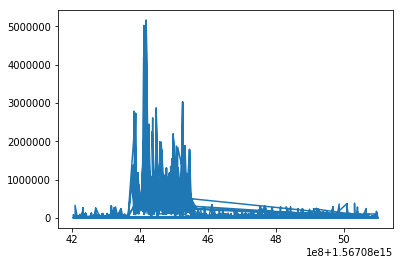

In [107]:
df1=df[df['target']=='ts-basic-service.default']
plt.plot(df1['timestamp'],df1['latency'])
df1['latency'].describe()

In [148]:
df=pd.read_csv('./event_title.csv')
df.head(10)

,trace_id,timestamp,latency,http_status,request_parent_id,request_id,source,http_name,target
0,e5509cc13e65c4f7dd466bd545db0467,1567080000000000,38326,200,45452fb3fef4b7a9,569d0169a84772e6,ts-station-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
1,3e4c92af33630580eca1ec210550f66f,1567080000000000,5079,200,778d0562f67eb944,532bd691d4cbed65,ts-basic-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
2,b6f73cac5f253f0776bc1bac01d4bbbe,1567080000000000,3861,200,None,76bc1bac01d4bbbe,istio-ingressgateway,ts-verification-code-service.default.svc.clust...,ts-verification-code-service.default
3,e5509cc13e65c4f7dd466bd545db0467,1567080000000000,4075,200,542883f06e91efe6,ac98f24e11f9690e,ts-basic-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
4,e5509cc13e65c4f7dd466bd545db0467,1567080000000000,3123,200,ac98f24e11f9690e,4d4ca4ed98c62c62,ts-station-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
5,3e4c92af33630580eca1ec210550f66f,1567080000000000,4652,200,778d0562f67eb944,668b1cbac2404f6a,ts-basic-service.default,ts-route-service.default.svc.cluster.local:111...,ts-route-service.default
6,e5509cc13e65c4f7dd466bd545db0467,1567080000000000,3982,200,31e904a9c0f0ab45,535bc287ce708b00,ts-basic-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
7,e5509cc13e65c4f7dd466bd545db0467,1567080000000000,134235,200,fdabcf92188d05d3,6d3e15474b53bfbf,ts-ticketinfo-service.default,ts-basic-service.default.svc.cluster.local:156...,ts-basic-service.default
8,3e4c92af33630580eca1ec210550f66f,1567080000000000,3949,200,8f5132dcbf63a35c,0839b27487612de7,ts-station-service.default,ts-station-service.default.svc.cluster.local:1...,ts-station-service.default
9,6d1bb6ea8133577502127e3401bbec41,1567080000000000,6962,200,b3ae66e9dcc4379f,60db6e95de03f4d0,ts-basic-service.default,ts-price-service.default.svc.cluster.local:165...,ts-price-service.default


In [14]:
for idx,trace_id in enumerate(df.head(10).trace_id.unique()):
    print(idx,trace_id)

0 442903d99172fa6a0b6b4fd22c5d8869
1 de760ce18a7a1da2ef1dfe166064fee5


# 获取普罗米修斯数据

In [12]:
from promalyze import Client

client = Client('http://192.168.115.36:31144')

ts_data = client.range_query('scrape_series_added') # returns PrometheusData object

ts = ts_data.timeseries[4] # returns a TimeSeries object

json_data = ts.as_json()

dataframe = ts.as_pandas_dataframe()#.reset_index()

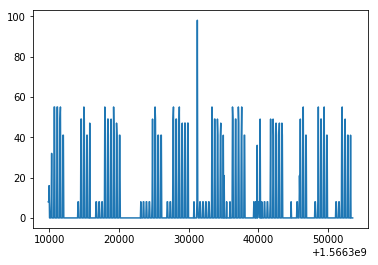

In [13]:
plt.plot(list(dataframe.index),list(dataframe['values'].astype('int64')))

# 获取influxdb的数据

In [117]:
#> SELECT * FROM "h2o_feet" WHERE time >= '2015-08-17T23:48:00Z' AND time <= '2015-08-18T00:30:00Z'
#print('数据库中的名称'+str(client.get_list_database()))
#print('数据库中的表'+str(client.query('show measurements;')))

## 获取时间段数据

In [46]:
client = DataFrameClient('192.168.115.31',34002,'root','','aiops_metric')
client.query('show measurements;')

ResultSet({'('measurements', None)': [{'name': 'ai.sawmill.test_platf_1@95956ad'}, {'name': 'ai.sawmill.test_platf_1@e8033e2'}, {'name': 'metric-admin-basic-info-service'}, {'name': 'metric-admin-order-service'}, {'name': 'metric-admin-route-service'}, {'name': 'metric-admin-travel-service'}, {'name': 'metric-admin-user-service'}, {'name': 'metric-assurance-service'}, {'name': 'metric-auth-service'}, {'name': 'metric-basic-service'}, {'name': 'metric-cancel-service'}, {'name': 'metric-config-service'}, {'name': 'metric-consign-price-service'}, {'name': 'metric-consign-service'}, {'name': 'metric-contacts-service'}, {'name': 'metric-food-map-service'}, {'name': 'metric-food-service'}, {'name': 'metric-inside-payment-service'}, {'name': 'metric-notification-service'}, {'name': 'metric-order-other-service'}, {'name': 'metric-order-service'}, {'name': 'metric-payment-service'}, {'name': 'metric-preserve-other-service'}, {'name': 'metric-preserve-service'}, {'name': 'metric-price-service'},

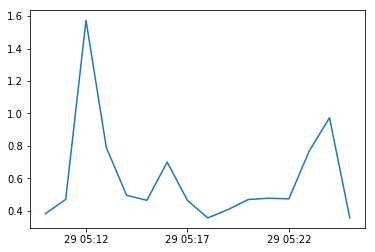

In [81]:
query = 'select * from "metric.ts-admin-basic-info-service" where time >= 1567055400000000000 and time<= 1567056300000000000'
result = dict(client.query(query,chunked=False))
a=result['metric.ts-admin-basic-info-service']
plt.plot(a['CPU使用率'])

In [103]:
def get_db(svc):
    client = DataFrameClient('192.168.115.31',34002,'root','','aiops_metric')#初始化
    query = 'select * from "{}" where time >= 1567055400000000000 and time<= 1567056300000000000'.format(svc)#time>now()-1h;
    result = dict(client.query(query,chunked=False))
    result = result[svc].reset_index().rename(columns={'index':'timestamp'})
    result['timestamp'] = result.apply(lambda x : x['timestamp'].timestamp(),axis=1)
    result['service'] = svc
    result['timestamp'] = result['timestamp']+28800
    return result
result = get_db('metric.ts-admin-basic-info-service')
result

,timestamp,CPU使用率,内存使用率,内存使用量,文件系统写入速率,文件系统读取速率,网络发送速率,网络接收速率,service
0,1567084200,0,0,830955520,0,0,2605,4537,metric.ts-admin-basic-info-service
1,1567084260,0,0,830955520,0,0,1968,297,metric.ts-admin-basic-info-service
2,1567084320,2,0,831053824,0,0,3354,1008,metric.ts-admin-basic-info-service
3,1567084380,1,0,831062016,0,0,2841,715,metric.ts-admin-basic-info-service
4,1567084440,0,0,831062016,0,0,2905,716,metric.ts-admin-basic-info-service
5,1567084500,0,0,831062016,0,0,2225,542,metric.ts-admin-basic-info-service
6,1567084560,1,0,831062016,0,0,3022,773,metric.ts-admin-basic-info-service
7,1567084620,0,0,831062016,0,0,2086,309,metric.ts-admin-basic-info-service
8,1567084680,0,0,831062016,0,0,1940,293,metric.ts-admin-basic-info-service
9,1567084740,0,0,831021056,0,0,2268,299,metric.ts-admin-basic-info-service


In [83]:
#因为容器数目不一致，需要转换名称，并且去数据库中读取成一个大表
def dflist_2_dblist(df):
    db_list=[]
    df_list=list(set(df['target']))
    for i in df_list:
        db_list.append('metric.ts-'+i.strip('defaults').strip('.-'))
    return db_list
db_list=dflist_2_dblist(df)
db_list

['metric.ts-travel-service',
 'metric.ts-train-service',
 'metric.ts-config-service',
 'metric.ts-security-service',
 'metric.ts-admin-basic-info-service',
 'metric.ts-user-service',
 'metric.ts-travel2-service',
 'metric.ts-ui-dashboard',
 'metric.ts-ticketinfo-service',
 'metric.ts-food-service',
 'metric.ts-travel-plan-service',
 'metric.ts-price-service',
 'metric.ts-verification-code-service',
 'metric.ts-assurance-service',
 'metric.ts-basic-service',
 'metric.ts-order-service',
 'metric.ts-food-map-service',
 'metric.ts-order-other-service',
 'metric.ts-station-service',
 'metric.ts-preserve-service',
 'metric.ts-contacts-service',
 'metric.ts-admin-user-service',
 'metric.ts-inside-payment-service',
 'metric.ts-admin-route-service',
 'metric.ts-payment-service',
 'metric.ts-auth-service',
 'metric.ts-admin-order-service',
 'metric.ts-route-service',
 'metric.ts-seat-service',
 'metric.ts-route-plan-service',
 'metric.ts-preserve-other-service',
 'metric.ts-admin-travel-service'

In [134]:
#读取fluxdb所有需要的数据为一个大表
def all_db(db_list):
    df=get_db(db_list[0])
    for i in db_list[1:]:
        df = pd.concat((df, get_db(i)))
    return df
db_data=all_db(db_list)
#db_data.to_csv('fluxdb.csv')
db_data

,CPU使用率,service,timestamp,内存使用率,内存使用量,文件系统写入速率,文件系统读取速率,网络发送速率,网络接收速率
0,21,metric.ts-travel-service,1567084200,0,1039515648,0,0,133302,43417
1,24,metric.ts-travel-service,1567084260,0,1039568896,0,0,151717,49692
2,29,metric.ts-travel-service,1567084320,0,1040400384,0,0,181574,59484
3,27,metric.ts-travel-service,1567084380,0,1040429056,0,0,161577,52905
4,21,metric.ts-travel-service,1567084440,0,1040379904,0,0,154591,50885
5,28,metric.ts-travel-service,1567084500,0,1040924672,0,0,174548,57405
6,27,metric.ts-travel-service,1567084560,0,1041010688,0,0,164718,54519
7,27,metric.ts-travel-service,1567084620,0,1040584704,0,0,169133,55575
8,26,metric.ts-travel-service,1567084680,0,1040723968,0,0,171663,56244
9,25,metric.ts-travel-service,1567084740,0,1039548416,0,0,128738,42483


# 时间转换

In [102]:
# '2015-08-28 16:43:37.283' --> 1440751417.283
# 或者 '2015-08-28 16:43:37' --> 1440751417.0
def string2timestamp(strValue):
 
    try:        
        d = datetime.datetime.strptime(strValue, "%Y-%m-%d %H:%M:%S.%f")
        t = d.timetuple()
        timeStamp = int(time.mktime(t))
        timeStamp = float(str(timeStamp) + str("%06d" % d.microsecond))/1000000
        print (timeStamp)
        return timeStamp
    except ValueError as e:
        print (e)
        d = datetime.datetime.strptime(str2, "%Y-%m-%d %H:%M:%S")
        t = d.timetuple()
        timeStamp = int(time.mktime(t))
        timeStamp = float(str(timeStamp) + str("%06d" % d.microsecond))/1000000
        print (timeStamp)
        return timeStamp
def timestamp2string(timeStamp):
    try:
        d = datetime.datetime.fromtimestamp(timeStamp)
        str1 = d.strftime("%Y-%m-%d %H:%M:%S.%f")
        # 2015-08-28 16:43:37.283000'
        return str1
    except Exception as e:
        print (e)
        return ''
now_str = datetime.datetime.now() 
#print(now_str)
now_timestamp=now_str.timestamp()
#print(now_timestamp)
print(timestamp2string(1567055400))
string2timestamp('2019-08-29 21:10:00.000000')
string2timestamp('2019-08-29 13:10:00.000000')

2019-08-29 13:10:00.000000
1567084200.0
1567055400.0


1567055400.0

In [101]:
1567084200-1567055400

28800

# 转换为invocation

In [114]:
pd.read_csv('grouped.csv')

,trace_id,Unnamed: 1,Unnamed: 0,timestamp,latency,http_status,endtime,s_t
0,00084bf4e31a5a323e2b69e8e2368ec6,34692,34692,1567084621987672,5057,200,1567084621992729,ts-station-service.default->ts-station-service...
1,00084bf4e31a5a323e2b69e8e2368ec6,34689,34689,1567084621966688,13457,200,1567084621980145,istio-ingressgateway->ts-order-service.default
2,00084bf4e31a5a323e2b69e8e2368ec6,26844,26844,1567084621909679,12180,200,1567084621921859,ts-order-service.default->ts-order-service.def...
3,00084bf4e31a5a323e2b69e8e2368ec6,12399,12399,1567084621914546,6323,200,1567084621920869,ts-order-service.default->ts-station-service.d...
4,000d0aded4af20d99c60af1936697b7d,12010,12010,1567084572798882,11513,200,1567084572810395,istio-ingressgateway->ts-order-other-service.d...
5,00340510346cd70a0ccc9d66eeff4443,26900,26900,1567084629666191,3763,200,1567084629669954,istio-ingressgateway->ts-verification-code-ser...
6,00340510346cd70a0ccc9d66eeff4443,4810,4810,1567084629608937,2760,200,1567084629611697,ts-verification-code-service.default->ts-verif...
7,004afa4242cb52f3909555143b01f54e,8770,8770,1567084834429113,12119,200,1567084834441232,ts-cancel-service.default->ts-cancel-service.d...
8,004afa4242cb52f3909555143b01f54e,1788,1788,1567084834433644,6074,200,1567084834439718,ts-cancel-service.default->ts-order-service.de...
9,004afa4242cb52f3909555143b01f54e,38038,38038,1567084834404832,13354,200,1567084834418186,istio-ingressgateway->ts-cancel-service.default


In [111]:
# 每个trace_id按照endtime降序进行排序，并转换为csv文件
#index需要咋csv中手动删除
def trans_csv(df):
    df['endtime']=df['timestamp']+df['latency']
    df=df.drop(['request_id','request_parent_id','http_name'],axis=1)
    grouped = df.groupby('trace_id').apply(lambda x: x.sort_values('endtime', ascending=False))
    grouped['s_t']=grouped['source'].str.cat(grouped['target'],sep='->')
    grouped=grouped.drop(columns=['target','source','trace_id'])
    grouped.to_csv('grouped.csv') 

In [113]:
trans_csv(df)

In [115]:
#以traceid为单位进行整合
def trans(df):
    for i in df.columns[1:]:
        df[i]=str(list(df[i]))
    df=df.drop_duplicates(['trace_id'])
    return df
#输入csv文件名
def trans_last(csv_name):
    df=pd.read_csv(csv_name)
    return df.groupby('trace_id').apply(trans).drop(columns='trace_id')

In [120]:
dfn=trans_last('grouped.csv')

In [121]:
dfn

,,timestamp,latency,http_status,endtime,s_t
trace_id,,,,,,
00084bf4e31a5a323e2b69e8e2368ec6,0,"[1567084621987670, 1567084621966680, 156708462...","[5057, 13457, 12180, 6323]","[200, 200, 200, 200]","[1567084621992720, 1567084621980140, 156708462...",['ts-station-service.default->ts-station-servi...
000d0aded4af20d99c60af1936697b7d,4,[1567084572798880],[11513],[200],[1567084572810390],['istio-ingressgateway->ts-order-other-service...
00340510346cd70a0ccc9d66eeff4443,5,"[1567084629666190, 1567084629608930]","[3763, 2760]","[200, 200]","[1567084629669950, 1567084629611690]",['istio-ingressgateway->ts-verification-code-s...
004afa4242cb52f3909555143b01f54e,7,"[1567084834429110, 1567084834433640, 156708483...","[12119, 6074, 13354, 4217]","[200, 200, 200, 200]","[1567084834441230, 1567084834439710, 156708483...",['ts-cancel-service.default->ts-cancel-service...
004e5fc45f895d1c7367f852406779cb,11,"[1567084912087810, 1567084912069670, 156708491...","[19697, 27233, 26071, 21398]","[200, 200, 200, 200]","[1567084912107510, 1567084912096900, 156708491...",['ts-station-service.default->ts-station-servi...
00608ee82a97aa30fb1783124195ac30,15,"[1567084884990610, 1567084884966380]","[660, 1833]","[304, 304]","[1567084884991270, 1567084884968220]",['ts-ui-dashboard.default->ts-ui-dashboard.def...
006daac022f98783f09380c45ab1051f,17,"[1567084254344520, 1567084254320060]","[681, 2103]","[304, 304]","[1567084254345200, 1567084254322160]",['ts-ui-dashboard.default->ts-ui-dashboard.def...
009f42de62e0494ce0d62ce7f74ef7af,19,"[1567085086351750, 1567085086301480, 156708508...","[8981, 4233, 3483]","[200, 200, 200]","[1567085086360730, 1567085086305710, 156708508...",['istio-ingressgateway->ts-admin-order-service...
00a54e81141f10f43300c9c30cfa7c8b,22,"[1567084385334360, 1567084385275680, 156708438...","[191545, 190134, 185137, 184455]","[200, 200, 200, 200]","[1567084385525900, 1567084385465810, 156708438...",['istio-ingressgateway->ts-admin-order-service...


# 整合

In [136]:
db_data1=db_data[['timestamp','service','CPU使用率','内存使用率']]
db_data1['service']=db_data1['service'].apply(lambda x:(x+'.').strip('metric').strip('.'))
db_data1

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,timestamp,service,CPU使用率,内存使用率
0,1567084200,ts-travel-service,21,0
1,1567084260,ts-travel-service,24,0
2,1567084320,ts-travel-service,29,0
3,1567084380,ts-travel-service,27,0
4,1567084440,ts-travel-service,21,0
5,1567084500,ts-travel-service,28,0
6,1567084560,ts-travel-service,27,0
7,1567084620,ts-travel-service,27,0
8,1567084680,ts-travel-service,26,0
9,1567084740,ts-travel-service,25,0


In [133]:
df1=df[['timestamp','source','target']]
df1.head()

,timestamp,source,target
0,1567084431270215,ts-station-service.default,ts-station-service.default
1,1567084431776851,ts-basic-service.default,ts-station-service.default
2,1567084429493868,istio-ingressgateway,ts-verification-code-service.default
3,1567084431975592,ts-basic-service.default,ts-station-service.default
4,1567084431969290,ts-station-service.default,ts-station-service.default


In [138]:
df1=df[['timestamp','source','target']]
df1['timestamp']=df1['timestamp'].apply(time_to_little)#利用字典取分段函数
df1['source']=df1['source'].apply(lambda x : ('.'+x).strip('default').strip('.'))
df1['target']=df1['target'].apply(lambda x : ('.'+x).strip('default').strip('.'))
df1=df1[~df1['source'].isin(['istio-ingressgateway'])]
df1

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,timestamp,source,target
0,1567084380,ts-station-service,ts-station-service
1,1567084380,ts-basic-service,ts-station-service
3,1567084380,ts-basic-service,ts-station-service
4,1567084380,ts-station-service,ts-station-service
5,1567084380,ts-basic-service,ts-route-service
6,1567084380,ts-basic-service,ts-station-service
7,1567084380,ts-ticketinfo-service,ts-basic-service
8,1567084380,ts-station-service,ts-station-service
9,1567084380,ts-basic-service,ts-price-service
10,1567084380,ts-food-service,ts-food-map-service


In [137]:
def time_to_little(data):
    n=(data-1567084200000000)//60000000  
    return 1567084200+n*60

In [167]:
def cpu_mem(df1,db_data1):
    src_cpu=[]
    src_mem=[]
    tar_cpu=[]
    tar_mem=[]
    for i in range(len(df1)):
        src=db_data1[(db_data1.timestamp==df1.iloc[i].values[0])&(db_data1.service==df1.iloc[i].values[1])]
        src_cpu.append(float(src.values[0][2]))
        src_mem.append(float(src.values[0][3]))
        tar=db_data1[(db_data1.timestamp==df1.iloc[i].values[0])&(db_data1.service==df1.iloc[i].values[2])]
        tar_cpu.append(float(tar.values[0][2]))
        tar_mem.append(float(tar.values[0][3]))
    df1['source_cpu']=src_cpu
    df1['source_mem']=src_mem
    df1['target_cpu']=tar_cpu
    df1['target_mem']=tar_mem
    return df1
df2=cpu_mem(df1,db_data1)

In [168]:
df2

,timestamp,source,target,source_cpu,source_mem,target_cpu,target_mem
0,1567084380,ts-station-service,ts-station-service,32,0,32,0
1,1567084380,ts-basic-service,ts-station-service,32,0,32,0
3,1567084380,ts-basic-service,ts-station-service,32,0,32,0
4,1567084380,ts-station-service,ts-station-service,32,0,32,0
5,1567084380,ts-basic-service,ts-route-service,32,0,15,0
6,1567084380,ts-basic-service,ts-station-service,32,0,32,0
7,1567084380,ts-ticketinfo-service,ts-basic-service,20,0,32,0
8,1567084380,ts-station-service,ts-station-service,32,0,32,0
9,1567084380,ts-basic-service,ts-price-service,32,0,4,0
10,1567084380,ts-food-service,ts-food-map-service,5,0,4,0


In [145]:
df2.to_csv('aaa.csv')

# 整合并转换

In [170]:
df3=df.drop(columns=['request_parent_id','request_id','http_name'])
df3['timestamp']=df3['timestamp'].apply(time_to_little)#利用字典取分段函数
df3['source']=df3['source'].apply(lambda x : ('.'+x).strip('default').strip('.'))
df3['target']=df3['target'].apply(lambda x : ('.'+x).strip('default').strip('.'))
df3=df3[~df3['source'].isin(['istio-ingressgateway'])]
df3

,trace_id,timestamp,latency,http_status,source,target
0,e5509cc13e65c4f7dd466bd545db0467,1567080000,38326,200,ts-station-service,ts-station-service
1,3e4c92af33630580eca1ec210550f66f,1567080000,5079,200,ts-basic-service,ts-station-service
3,e5509cc13e65c4f7dd466bd545db0467,1567080000,4075,200,ts-basic-service,ts-station-service
4,e5509cc13e65c4f7dd466bd545db0467,1567080000,3123,200,ts-station-service,ts-station-service
5,3e4c92af33630580eca1ec210550f66f,1567080000,4652,200,ts-basic-service,ts-route-service
6,e5509cc13e65c4f7dd466bd545db0467,1567080000,3982,200,ts-basic-service,ts-station-service
7,e5509cc13e65c4f7dd466bd545db0467,1567080000,134235,200,ts-ticketinfo-service,ts-basic-service
8,3e4c92af33630580eca1ec210550f66f,1567080000,3949,200,ts-station-service,ts-station-service
9,6d1bb6ea8133577502127e3401bbec41,1567080000,6962,200,ts-basic-service,ts-price-service
10,96cb5618c3137ac209dccc15a98f0fe4,1567080000,6871,200,ts-food-service,ts-food-map-service


In [171]:
db_data2=db_data
db_data2['service']=db_data2['service'].apply(lambda x:(x+'.').strip('metric').strip('.'))
db_data1

,timestamp,service,CPU使用率,内存使用率
0,1567084200,ts-travel-service,21,0
1,1567084260,ts-travel-service,24,0
2,1567084320,ts-travel-service,29,0
3,1567084380,ts-travel-service,27,0
4,1567084440,ts-travel-service,21,0
5,1567084500,ts-travel-service,28,0
6,1567084560,ts-travel-service,27,0
7,1567084620,ts-travel-service,27,0
8,1567084680,ts-travel-service,26,0
9,1567084740,ts-travel-service,25,0


In [172]:
def cpu_mem(df1,db_data1):
    src_cpu=[]
    src_mem=[]
    tar_cpu=[]
    tar_mem=[]
    for i in range(len(df1)):
        src=db_data1[(db_data1.timestamp==df1.iloc[i].values[1])&(db_data1.service==df1.iloc[i].values[4])]
        src_cpu.append(float(src.values[0][2]))
        src_mem.append(float(src.values[0][3]))
        #tar=db_data1[(db_data1.timestamp==df1.iloc[i].values[1])&(db_data1.service==df1.iloc[i].values[5])]
        #tar_cpu.append(float(tar.values[0][2]))
        #tar_mem.append(float(tar.values[0][3]))
    df1['source_cpu']=src_cpu
    df1['source_mem']=src_mem
    #df1['target_cpu']=tar_cpu
    #df1['target_mem']=tar_mem
    return df1
df4=cpu_mem(df3,db_data1)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [180]:
db_data1[(db_data1.timestamp==df3.iloc[0].values[1])&(db_data1.service==df3.iloc[0].values[4])]

,timestamp,service,CPU使用率,内存使用率


In [186]:
db_data1.timestamp==df3.iloc[0].values[1]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
      ...  
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
Name: timestamp, Length: 560, dtype: bool